In [566]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from fancyimpute import KNN    
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import uniform
from sklearn.preprocessing import StandardScaler,OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, auc, roc_curve, precision_recall_curve, average_precision_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix

In [4]:
%matplotlib inline

In [5]:
weekly = pd.read_csv(filepath_or_buffer='Courier_weekly_data.csv')

In [6]:
weekly.head(20)

,courier,week,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17
0,3767,2,6,34,38,0.0789,0.9211,140.4737,0.1316,2162.4737,0.7632,7.340776,8,20.208158,5.236316,0.8158,43.384804,1,19
1,3767,4,-1,42,37,0.0000,1.0000,135.5946,0.0811,2097.4054,0.9459,11.883784,19,18.855405,5.689459,0.8919,35.078042,3,11
2,3767,5,24,41,43,0.0233,0.9767,131.0930,0.0233,2043.8837,0.9302,7.072100,16,18.925116,5.138605,0.9302,31.455285,1,10
3,3767,6,-22,65,66,0.0606,0.9394,120.1515,0.0000,2124.2727,0.7727,7.356567,33,18.259697,4.704394,0.7879,34.252991,1,30
4,6282,2,9,33,27,0.0741,0.9259,100.0000,0.0370,4075.7407,0.8889,8.501233,5,26.863704,4.828519,0.8889,46.478114,1,4
5,6282,3,-20,42,56,0.0536,0.9464,113.4821,0.0357,4777.0714,0.9107,8.210125,16,23.651786,5.553571,0.9107,79.407407,2,5
6,6282,4,9,22,32,0.1250,0.8750,105.0000,0.0938,5744.1875,0.8125,8.285422,12,18.180937,5.834375,0.7813,87.250000,1,2
7,6282,5,21,31,48,0.0417,0.9583,117.2500,0.0833,4011.7708,0.9167,9.768052,17,20.346667,5.615417,0.9167,85.083333,2,9
8,6282,6,-12,52,72,0.0694,0.9306,107.6389,0.0417,4000.3333,0.8472,7.736114,17,21.941111,5.093056,0.8750,73.904915,1,13
9,6282,7,1,40,56,0.0893,0.9107,124.3750,0.0893,3192.0000,0.9107,7.405355,11,18.591071,5.353214,0.9107,65.618750,2,4


In [7]:
weekly[(weekly.week==11) | (weekly.week==10) | (weekly.week==9)]['courier'].drop_duplicates().count()


387

In [8]:
weeks=weekly.copy()

In [9]:
def week_label(row):
    courier_set=weekly[(weekly.courier==row['courier']) & ((weekly.week==9) | (weekly.week==10) |(weekly.week==11))]
    if courier_set['courier'].count() == 0:
        label=1
    else: 
        label=0
    return label

In [10]:
weeks['label']=weeks.apply(week_label, axis=1)


In [11]:
weeks=weeks[(weeks.week<8)]

In [12]:
weeks.head(20)

,courier,week,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,label
0,3767,2,6,34,38,0.0789,0.9211,140.4737,0.1316,2162.4737,0.7632,7.340776,8,20.208158,5.236316,0.8158,43.384804,1,19,1
1,3767,4,-1,42,37,0.0000,1.0000,135.5946,0.0811,2097.4054,0.9459,11.883784,19,18.855405,5.689459,0.8919,35.078042,3,11,1
2,3767,5,24,41,43,0.0233,0.9767,131.0930,0.0233,2043.8837,0.9302,7.072100,16,18.925116,5.138605,0.9302,31.455285,1,10,1
3,3767,6,-22,65,66,0.0606,0.9394,120.1515,0.0000,2124.2727,0.7727,7.356567,33,18.259697,4.704394,0.7879,34.252991,1,30,1
4,6282,2,9,33,27,0.0741,0.9259,100.0000,0.0370,4075.7407,0.8889,8.501233,5,26.863704,4.828519,0.8889,46.478114,1,4,0
5,6282,3,-20,42,56,0.0536,0.9464,113.4821,0.0357,4777.0714,0.9107,8.210125,16,23.651786,5.553571,0.9107,79.407407,2,5,0
6,6282,4,9,22,32,0.1250,0.8750,105.0000,0.0938,5744.1875,0.8125,8.285422,12,18.180937,5.834375,0.7813,87.250000,1,2,0
7,6282,5,21,31,48,0.0417,0.9583,117.2500,0.0833,4011.7708,0.9167,9.768052,17,20.346667,5.615417,0.9167,85.083333,2,9,0
8,6282,6,-12,52,72,0.0694,0.9306,107.6389,0.0417,4000.3333,0.8472,7.736114,17,21.941111,5.093056,0.8750,73.904915,1,13,0
9,6282,7,1,40,56,0.0893,0.9107,124.3750,0.0893,3192.0000,0.9107,7.405355,11,18.591071,5.353214,0.9107,65.618750,2,4,0


In [13]:
def max_consecutive(vector):
    longest = 0
    current = 0
    for num in vector:
        if num == 1:
            current += 1
        else:
            longest = max(longest, current)
            current = 0

    return max(longest, current)
    

In [177]:
def latest_streak(series):
    week_vector=[0,0,0,0,0,0,0,0]
    count=0
    
    for i in series:
        week_vector[i]=1
    reversed_week=list(reversed(week_vector))
    for i in reversed_week:
        if i==1:
            count+=1
        else: 
            break
    return count

    

In [14]:
max_consecutive([0,1,1,1,0,0,1,0,1,1,1,1,1,1,0])

6

In [15]:
def max_streak(series):
    week_vector=[0,0,0,0,0,0,0,0]
    
    for i in series:
        week_vector[i]=1
    streak=max_consecutive(week_vector)
    return streak
    
        
        

In [98]:
def get_range(series):
    return max(series)-min(series)

In [16]:
def lifetime_mean(series):
    return np.sum(series)/8

In [512]:
aggreg=get_range
aggreg='mean'
#aggreg=lifetime_mean



In [513]:
gold=weeks.groupby(['courier','label'], as_index=False )\
.agg({'week':['count', max_streak,latest_streak],\
              'feature_1':['mean',lifetime_mean],\
               'feature_2':['mean',lifetime_mean],'feature_3':['mean',lifetime_mean]\
      ,'feature_4':['mean',lifetime_mean],'feature_5':['mean',lifetime_mean]\
      ,'feature_6':['mean',lifetime_mean],'feature_7':['mean',lifetime_mean]\
      ,'feature_8':['mean',lifetime_mean],'feature_9':['mean',lifetime_mean]\
      ,'feature_10':['mean',lifetime_mean],'feature_11':['mean',lifetime_mean]\
     ,'feature_12':['mean',lifetime_mean],'feature_13':['mean',lifetime_mean]\
     ,'feature_14':['mean',lifetime_mean],'feature_15':['mean',lifetime_mean]\
     ,'feature_16':['mean',lifetime_mean],'feature_17':['mean',lifetime_mean]})

In [1088]:
gold=weeks.groupby(['courier','label'], as_index=False )\
.agg({'week':['count', max_streak,latest_streak],\
              'feature_1':'mean',\
               'feature_2':'mean','feature_3':'mean'\
      ,'feature_4':'mean','feature_5':'mean'\
      ,'feature_6':'mean','feature_7':'mean'\
      ,'feature_8':'mean','feature_9':'mean'\
      ,'feature_10':'mean','feature_11':'mean'\
     ,'feature_12':'mean','feature_13':'mean'\
     ,'feature_14':'mean','feature_15':'mean'\
     ,'feature_16':'mean','feature_17':'mean'})

In [1089]:
gold=weeks.groupby(['courier','label'], as_index=False )\
.agg({'week':['count', max_streak,latest_streak],\
              'feature_1':aggreg,\
               'feature_2':aggreg,'feature_3':aggreg\
      ,'feature_4':aggreg,'feature_5':aggreg\
      ,'feature_6':aggreg,'feature_7':aggreg\
      ,'feature_8':aggreg,'feature_9':aggreg\
      ,'feature_10':aggreg,'feature_11':aggreg\
     ,'feature_12':aggreg,'feature_13':aggreg\
     ,'feature_14':aggreg,'feature_15':aggreg\
     ,'feature_16':aggreg,'feature_17':aggreg})

In [1090]:
gold[(gold.courier==6282)]

courier label  week                          feature_1  feature_2 feature_3  \
                count max_streak latest_streak      mean       mean      mean   
1    6282     0     6          6             6  1.333333  36.666667      48.5   

  feature_4 feature_5    ...       feature_8 feature_9 feature_10 feature_11  \
       mean      mean    ...            mean      mean       mean       mean   
1  0.075517  0.924483    ...      4300.18395  0.881117   8.317717       13.0   

  feature_12 feature_13 feature_14 feature_15 feature_16 feature_17  
        mean       mean       mean       mean       mean       mean  
1  21.595879   5.379692    0.88055  72.957087        1.5   6.166667  

[1 rows x 22 columns]

Text(0.5,1,'churned')

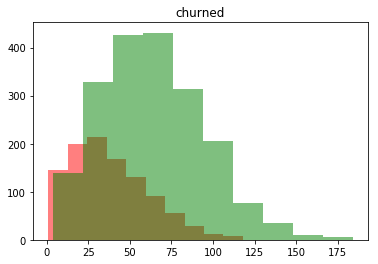

In [1091]:
#normalize histogram
plt.hist(weeks[(weeks.label==1)].feature_3,alpha=0.5,color='red')
plt.hist(weeks[(weeks.label==0)].feature_3,alpha=0.5,color='green')
plt.title('churned')

In [1092]:
gold.columns = [gold + '_' + i for gold, i in zip(gold.columns.get_level_values(0), gold.columns.get_level_values(1).astype(str))]

In [1093]:
gold=gold.rename(columns={'courier_':'courier','label_':'y'})

In [1094]:
gold.set_index('courier', inplace=True)

Text(0.5,1,'churned')

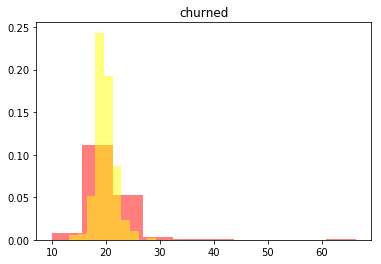

In [1095]:
plt.hist(gold[(gold.y==1)].feature_12_mean,alpha=0.5,color='red',density=1)
plt.hist(gold[(gold.y==0)].feature_12_mean,alpha=0.5,color='yellow',density=1)
plt.title('churned')

In [1096]:
# there seems to be a difference between the mean of feature 2. 3. and 11

In [1097]:
gold.head()

,y,week_count,week_max_streak,week_latest_streak,feature_1_mean,feature_2_mean,feature_3_mean,feature_4_mean,feature_5_mean,feature_6_mean,...,feature_8_mean,feature_9_mean,feature_10_mean,feature_11_mean,feature_12_mean,feature_13_mean,feature_14_mean,feature_15_mean,feature_16_mean,feature_17_mean
courier,,,,,,,,,,,,,,,,,,,,,
3767,1,4,3,0,1.750000,45.500000,46.000,0.040700,0.959300,131.82820,...,2107.008875,0.853000,8.413307,19.000,19.062094,5.192193,0.856450,36.042781,1.5,17.500000
6282,0,6,6,6,1.333333,36.666667,48.500,0.075517,0.924483,111.29100,...,4300.183950,0.881117,8.317717,13.000,21.595879,5.379692,0.880550,72.957087,1.5,6.166667
10622,1,2,2,0,-3.500000,84.500000,54.000,0.119050,0.880950,100.15875,...,2576.890500,0.623800,10.199895,20.500,21.568016,4.179873,0.660300,35.646190,2.5,15.500000
13096,0,2,2,0,0.000000,59.000000,89.500,0.161600,0.838400,104.29600,...,4590.275250,0.686000,9.630672,34.500,17.902412,5.166684,0.720300,84.347978,3.0,19.000000
14261,1,8,8,8,-3.625000,75.500000,70.875,0.018425,0.981575,115.62990,...,3870.750225,0.892537,10.001638,34.875,21.166889,5.433909,0.900662,49.311612,2.5,6.750000


In [1098]:
gold=gold[['y','week_count','week_max_streak','week_latest_streak','feature_1_mean','feature_2_mean','feature_3_mean','feature_11_mean']]

In [1099]:
# look at the distribution per class for the features to choose the correct aggregation
#look at normalizing the histogram

In [1100]:
#adding lifetime info
lifetime = pd.read_csv(filepath_or_buffer='Courier_lifetime_data.csv')




In [1101]:
lifetime.head()

,courier,feature_1,feature_2
0,208,a,25.0
1,218,c,0.0
2,225,c,NaN
3,231,c,0.0
4,242,c,NaN


In [1102]:
gen_le = LabelEncoder()
gen_labels = gen_le.fit_transform(lifetime['feature_1'])
lifetime['feature_1'] = gen_labels

In [1103]:
lifetime_encoded= pd.get_dummies(lifetime, columns=['feature_1'])

In [1104]:
#lifetime_encoded=lifetime.copy()

In [1105]:
lifetime_encoded.set_index('courier', inplace=True)

In [1106]:
lifetime_encoded.head()

,feature_2,feature_1_0,feature_1_1,feature_1_2,feature_1_3
courier,,,,,
208,25.0,1,0,0,0
218,0.0,0,0,1,0
225,NaN,0,0,1,0
231,0.0,0,0,1,0
242,NaN,0,0,1,0


In [1107]:
#lifetime_encoded=lifetime_encoded.drop('feature_2', axis=1)

In [1108]:
gold=gold.merge(lifetime_encoded, how='left', left_index=True, right_index=True)


In [1109]:
gold.head()

,y,week_count,week_max_streak,week_latest_streak,feature_1_mean,feature_2_mean,feature_3_mean,feature_11_mean,feature_2,feature_1_0,feature_1_1,feature_1_2,feature_1_3
courier,,,,,,,,,,,,,
3767,1,4,3,0,1.750000,45.500000,46.000,19.000,33.0,0,1,0,0
6282,0,6,6,6,1.333333,36.666667,48.500,13.000,35.0,1,0,0,0
10622,1,2,2,0,-3.500000,84.500000,54.000,20.500,35.0,0,1,0,0
13096,0,2,2,0,0.000000,59.000000,89.500,34.500,35.0,1,0,0,0
14261,1,8,8,8,-3.625000,75.500000,70.875,34.875,44.0,1,0,0,0


In [1110]:
gold =  pd.DataFrame(KNN(k=2).fit_transform(gold), columns=gold.columns, index=gold.index) 

Imputing row 1/729 with 0 missing, elapsed time: 0.092
Imputing row 101/729 with 0 missing, elapsed time: 0.093
Imputing row 201/729 with 0 missing, elapsed time: 0.094
Imputing row 301/729 with 0 missing, elapsed time: 0.095
Imputing row 401/729 with 0 missing, elapsed time: 0.096
Imputing row 501/729 with 0 missing, elapsed time: 0.096
Imputing row 601/729 with 0 missing, elapsed time: 0.096
Imputing row 701/729 with 0 missing, elapsed time: 0.097


Text(0.5,1,'churned')

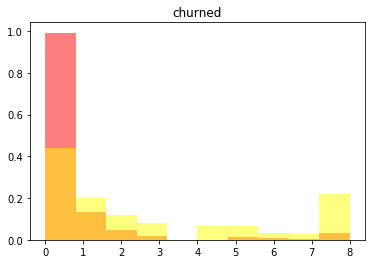

In [1111]:
plt.hist(gold[(gold.y==1)].week_latest_streak,alpha=0.5,color='red',density=1)
plt.hist(gold[(gold.y==0)].week_latest_streak,alpha=0.5,color='yellow',density=1)
plt.title('churned')

In [1112]:
golden_x= gold.drop(['y'], axis=1)
golden_y= gold['y']

In [1113]:
x_train, x_test, y_train, y_test = train_test_split(golden_x,golden_y , test_size=0.25)

In [1114]:
scaler=StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

In [1115]:
y_train.value_counts()


1.0    273
0.0    273
Name: y, dtype: int64

In [1116]:
clf = LogisticRegression()

In [1117]:
logisticRegr = LogisticRegression()
logisticRegr.fit(X=x_train, y=y_train)
test_y_pred = logisticRegr.predict(x_test)
cf_mt = confusion_matrix(y_test, test_y_pred)
print('Intercept: ' + str(logisticRegr.intercept_))
print('Regression: ' + str(logisticRegr.coef_))
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logisticRegr.score(x_test, y_test)))
print(classification_report(y_test, test_y_pred))

Intercept: [-0.02731645]
Regression: [[-1.59994136  1.25576721 -0.33314087 -0.49271082 -0.11323941 -0.91769307
   0.11363372 -0.01817742 -0.00704642 -0.01613665  0.28715134 -0.02620605]]
Accuracy of logistic regression classifier on test set: 0.77
             precision    recall  f1-score   support

        0.0       0.80      0.72      0.76        92
        1.0       0.74      0.82      0.78        91

avg / total       0.77      0.77      0.77       183



Text(0.5,15,'Predicted label')

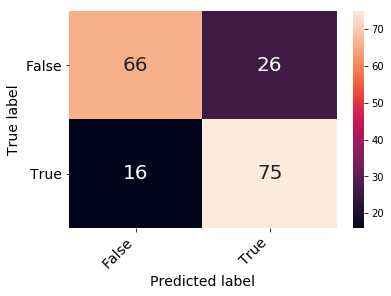

In [1118]:
confusion_matrix_df = pd.DataFrame(cf_mt, ('False', 'True'), ('False', 'True'))
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={"size": 20}, fmt="d")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize = 14)
plt.ylabel('True label', fontsize = 14)
plt.xlabel('Predicted label', fontsize = 14)

0.7704918032786885
Accuracy: 0.723 (0.099)
Logloss: -0.532 (0.099)
AUC: 0.830 (0.078)
[[66 26]
 [16 75]]


Text(0.5,15,'Predicted label')

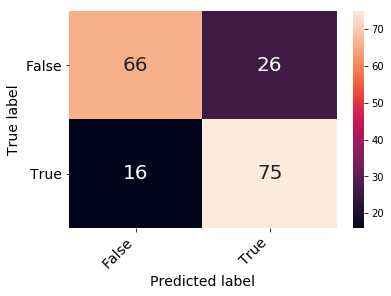

In [1119]:
clf.fit(x_train,y_train)
print(clf.score(x_test, y_test))
seed = 7
k_fold = KFold(n_splits=10, random_state=seed)
scoring = 'accuracy'
results = results=cross_val_score(clf, x_test, y_test, cv=k_fold, n_jobs=1, scoring=scoring)
print("Accuracy: %.3f (%.3f)" % (results.mean(), results.std()))
scoring = 'neg_log_loss'
results = results=cross_val_score(clf, x_test, y_test, cv=k_fold, n_jobs=1, scoring=scoring)
print("Logloss: %.3f (%.3f)" % (results.mean(), results.std()))
scoring = 'roc_auc'
results = results=cross_val_score(clf, x_test, y_test, cv=k_fold, n_jobs=1, scoring=scoring)
print("AUC: %.3f (%.3f)" % (results.mean(), results.std()))

clf.fit(x_train,y_train)
predicted=clf.predict(x_test)
matrix = confusion_matrix(y_test, predicted)
print(matrix)


confusion_matrix_df = pd.DataFrame(matrix, ('False', 'True'), ('False', 'True'))
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={"size": 20}, fmt="d")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize = 14)
plt.ylabel('True label', fontsize = 14)
plt.xlabel('Predicted label', fontsize = 14)

             precision    recall  f1-score   support

        0.0       0.80      0.72      0.76        92
        1.0       0.74      0.82      0.78        91

avg / total       0.77      0.77      0.77       183



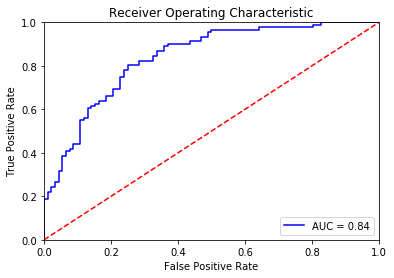

In [1120]:
probs = clf.predict_proba(x_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
print(classification_report(y_test, test_y_pred))
plt.show()

Text(0.5,1,'2-class Precision-Recall curve: AP=0.83')

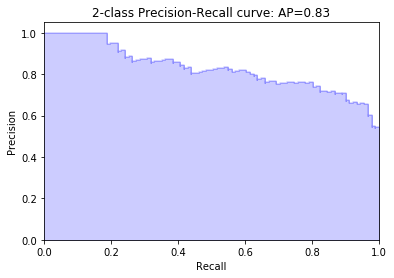

In [1121]:
average_precision = average_precision_score(y_test, preds)
precision, recall, _ = precision_recall_curve(y_test, preds)

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

In [ ]:
penalty = ['l2']
#C = np.logspace(0, 4, 10)
C = uniform(loc=0, scale=4)
hyperparameters = dict(C=C, penalty=penalty)

#clf_CV = GridSearchCV(clf, hyperparameters, cv=5, verbose=0)
clf_CV = RandomizedSearchCV(clf, hyperparameters, random_state=1, n_iter=10, cv=5, verbose=0, n_jobs=-1)
best_model = clf_CV.fit(x_train, y_train)
clf_CV.fit(x_train,y_train)
print(clf_CV.score(x_test, y_test))
seed = 7
k_fold = KFold(n_splits=10, random_state=seed)
scoring = 'accuracy'
results = results=cross_val_score(clf_CV, x_test, y_test, cv=k_fold, n_jobs=1, scoring=scoring)
print("Accuracy: %.3f (%.3f)" % (results.mean(), results.std()))
scoring = 'neg_log_loss'
results = results=cross_val_score(clf_CV, x_test, y_test, cv=k_fold, n_jobs=1, scoring=scoring)
print("Logloss: %.3f (%.3f)" % (results.mean(), results.std()))
scoring = 'roc_auc'
results = results=cross_val_score(clf_CV, x_test, y_test, cv=k_fold, n_jobs=1, scoring=scoring)
print("AUC: %.3f (%.3f)" % (results.mean(), results.std()))

predicted=best_model.predict(x_test)
matrix = confusion_matrix(y_test, predicted)


confusion_matrix_df = pd.DataFrame(matrix, ('False', 'True'), ('False', 'True'))
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={"size": 20}, fmt="d")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize = 14)
plt.ylabel('True label', fontsize = 14)
plt.xlabel('Predicted label', fontsize = 14)

0.7704918032786885
Accuracy: 0.744 (0.074)
Logloss: -0.669 (0.005)


In [ ]:

probs = best_model.predict_proba(x_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

print(accuracy_score(y_test, predicted))

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
average_precision = average_precision_score(y_test, preds)
precision, recall, _ = precision_recall_curve(y_test, preds)

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

In [ ]:
clf = RandomForestClassifier(n_jobs=-1)

param_grid = {
    'min_samples_split': [3, 5, 10], 
    'n_estimators' : [100, 300],
    'max_depth': [3, 5, 15, 25],
    'max_features': [3, 5, 10, 20]
}

scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score)
}

In [ ]:
def grid_search_wrapper(refit_score='precision_score'):
    """
    fits a GridSearchCV classifier using refit_score for optimization
    prints classifier performance metrics
    """
    skf = StratifiedKFold(n_splits=10)
    grid_search = GridSearchCV(clf, param_grid, scoring=scorers, refit=refit_score,
                           cv=skf, return_train_score=True, n_jobs=-1)
    grid_search.fit(x_train.values, y_train.values)

    
    y_pred = grid_search.predict(x_test.values)

    print('Best params for {}'.format(refit_score))
    print(grid_search.best_params_)

    # confusion matrix on the test data.
    print('\nConfusion matrix of Random Forest optimized for {} on the test data:'.format(refit_score))
    print(pd.DataFrame(confusion_matrix(y_test, y_pred),
                 columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))
    return grid_search

In [ ]:
#grid_search_clf = grid_search_wrapper(refit_score='precision_score')


In [ ]:
randomForest = RandomForestClassifier( max_depth=25, max_features=3, min_samples_split=10, n_estimators=300)
randomForest.fit(x_train, y_train)
print('Accuracy of random forest classifier on test set: {:.2f}'.format(randomForest.score(x_test, y_test)))

In [ ]:
test_y_pred = randomForest.predict(x_test)
cf_mt = confusion_matrix(y_test, test_y_pred)
cf_mt

In [ ]:
print(randomForest.score(x_test, y_test))
seed = 7
k_fold = KFold(n_splits=10, random_state=seed)
scoring = 'accuracy'
results = results=cross_val_score(randomForest, x_test, y_test, cv=k_fold, n_jobs=1, scoring=scoring)
print("Accuracy: %.3f (%.3f)" % (results.mean(), results.std()))
scoring = 'neg_log_loss'
results = results=cross_val_score(randomForest, x_test, y_test, cv=k_fold, n_jobs=1, scoring=scoring)
print("Logloss: %.3f (%.3f)" % (results.mean(), results.std()))
scoring = 'roc_auc'
results = results=cross_val_score(randomForest, x_test, y_test, cv=k_fold, n_jobs=1, scoring=scoring)
print("AUC: %.3f (%.3f)" % (results.mean(), results.std()))

randomForest.fit(x_train,y_train)
predicted=randomForest.predict(x_test)
matrix = confusion_matrix(y_test, predicted)
print(matrix)


confusion_matrix_df = pd.DataFrame(matrix, ('False', 'True'), ('False', 'True'))
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={"size": 20}, fmt="d")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize = 14)
plt.ylabel('True label', fontsize = 14)
plt.xlabel('Predicted label', fontsize = 14)

In [ ]:
probs = randomForest.predict_proba(x_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)


plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
randomForest.feature_importances_

In [ ]:
importances = randomForest.feature_importances_
std = np.std([tree.feature_importances_ for tree in randomForest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(golden_x.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(golden_x.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(golden_x.shape[1]), indices)
plt.xlim([-1, golden_x.shape[1]])
plt.show()